In [ ]:
#23MDT1059 RUSHIKESH UPADHYE

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image or numpy array to PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to range [-1, 1]
])


train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

print("Data loading complete!")


100%|██████████| 170M/170M [00:03<00:00, 54.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Data loading complete!


In [ ]:
#construct cnn
#convolutional layer 1: 32filters,kernel 3*3,Relu activation
#convolutional layer 2: 64filters,kernel 3*3,Relu activation
#maxpooling layer:pool size 2*2
#flatten the output of the final convolutional layer
#fullly connected laye:128 neurons with ReLU activation
#output layer : 10 neurons with softmax activation
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        # Updated input size for fc1: 64 * 16 * 16
        self.fc1 = nn.Linear(64 * 16 * 16, 128)  # After pooling, input size = 16x16
        self.fc2 = nn.Linear(128, 10)  # Output layer

    def forward(self, x):
        # Convolutional layers with ReLU activation
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))

        # Max pooling
        x = self.pool(x)

        # Flatten
        x = torch.flatten(x, start_dim=1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x), dim=1)  # Log-Softmax for classification

        return x

# Instantiate the model
model = SimpleCNN()
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
#perform a forward pass to compute output.calculate cross entropy
# Loss function
criterion = nn.CrossEntropyLoss()

# Get a batch of training data
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Forward pass
outputs = model(images)

# Calculate loss
loss = criterion(outputs, labels)
print("Loss:", loss.item())


Loss: 2.311837673187256


In [ ]:
#upadate weights using the Adam optimizer with learning rate 0.0001
import torch.optim as optim

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Zero the parameter gradients
optimizer.zero_grad()

# Backward pass and optimization
loss.backward()
optimizer.step()

print("Weights updated!")


Weights updated!


Epoch 1/10, Loss: 1.2399
Epoch 2/10, Loss: 1.1398
Epoch 3/10, Loss: 1.0600
Epoch 4/10, Loss: 0.9939
Epoch 5/10, Loss: 0.9379
Epoch 6/10, Loss: 0.8890
Epoch 7/10, Loss: 0.8450
Epoch 8/10, Loss: 0.8055
Epoch 9/10, Loss: 0.7653
Epoch 10/10, Loss: 0.7314


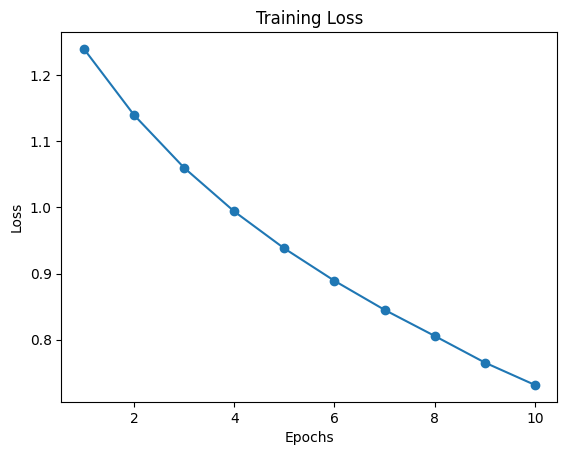

In [ ]:
#train the model for 5 epochs tracking and plotting loss after each epoch
import matplotlib.pyplot as plt

num_epochs = 10
train_loss = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track loss
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_loss.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Plot training loss
plt.plot(range(1, num_epochs + 1), train_loss, marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()



In [ ]:
#after training evalute model accuracy on the test set
def evaluate_model(model, test_loader):
    correct = 0
    total = 0
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy on the test set: {accuracy:.2f}%")

evaluate_model(model, test_loader)


Accuracy on the test set: 67.17%
